## Analysis of how flight sample length affects cloud variable error
This notebook was prompted by the question of how long an aircraft needs to sample a cloud field in order for the sampling uncertainty to be suitably low. The exact threshold depends on the variable and situation, so here we are looking to understand the relationship between flight sample length and sampling error for a number of variables. 

To start off, we  use satellite data (specifically the MODIS L2 cloud product) as our sandbox, and consider the variables cloud droplet effective radius, cloud optical thickness, cloud water path, and cloud fraction. So to restate our question: given a particular box of 1&deg;x1&deg; of MODIS imagery, and a linear flight path through that box of length *y* km, how does the error in e.g. cloud water path measured along the flight path vs. over the entire box decrease as y increases? 

A key choice is how to create the flight path. In contrast to studies of this nature using Large Eddy Simulation (LES) instead of natural satellite imagery, the underlying cloud field may have large gradients across the region of interest, and so it matters whether the flight path is in the center of the image, or the edge, and what shape and orientation it takes. To address this, we define a SampleStrategy class below, which allows us to try multiple strategies.



We sample randomly from a large selection of MODIS images, and within each image sample multiple 1&deg;x1&deg; boxes.


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil
import numpy as np
import os
import glob
import random
import time
import matplotlib.patches as patches
import multiprocessing as mp
import warnings
import pickle
print('imported!')
%matplotlib inline

imported!


In [4]:
#Setting up data and variables names
all_modis_files = glob.glob('/home/disk/eos9/jkcm/Data/modis/MYD06_L2/MYD06_L2.*.hdf')
modis_vars = ['Cloud_Effective_Radius', 'Cloud_Optical_Thickness', 'Cloud_Water_Path', 'cloud_top_height_1km']
col_names = ['Cloud_Frac'] + modis_vars
col_units = ['%', 'um', '', 'g/m2', 'm']
random.seed(0)

### Defining SampleStrategy
Below is the SampleStrategy class. The two key behaviors of a SampleStrategy are 1) given a 1x1 degree box and a particular variable determining the length of a sample (e.g. kilometers flown), it returns a sample over that 1x1 box (e.g. "a line of X kilometers horizontally across the middle of the image"), and 2) it defines how to vary that length of sample (e.g. "try sampling 10km, 20km, 50km, and 100km"). 

In [5]:
class SampleStrategy:
    """Define a strategy for sampling a 100x100pixel array
    """
    def __init__(self, samplefunction, length_var, length_var_name):
        self.samplefunction = samplefunction
        self.length_var = length_var
        self.length_var_name = length_var_name
        
    def sample(self, data, length):
        data_slice = self.samplefunction(data.shape, length)
        if type(data_slice) == tuple: # returning a slice TODO standardize this
            data_sample = data[data_slice]
        elif type(data_slice) == np.ndarray: #returning an index array, need to flatten first:
            data_sample = data.flatten()[np.where(sample.flatten())]
        return (np.nanmean(data_sample), np.nanstd(data_sample), np.sum(~np.isnan(data_sample)))
#         return self.samplefunction(data, length)
    
    def visualize(self):
        fig, ax = plt.subplots(ncols=len(self.length_var), figsize=(5*len(self.length_var), 5), sharex=True, sharey=True)
        for i,length in enumerate(self.length_var):
            arr = np.zeros((100,100))
            data_slice = self.samplefunction(arr.shape, length)
            if type(data_slice) == tuple:
                arr[data_slice] = 1
            elif type(data_slice)== np.ndarray:
                arr = data_slice
            ax[i].imshow(arr, cmap='Reds',  interpolation='nearest', vmin=0, vmax=1)
            ax[i].set_title(f'length var = {length}')
        fig.suptitle(self.length_var_name, y=1.06, fontsize=15)
        fig.tight_layout()

To understand this, we start by considering a straight line flight path, always centered on the center of the box, and vary the length from 10, 30, 60, 100 km.
First we define a general function that will give us flightpath samples, given a length of flightpath and some data array (a 1&deg;x1&deg; of e.g. cloud effective radius).


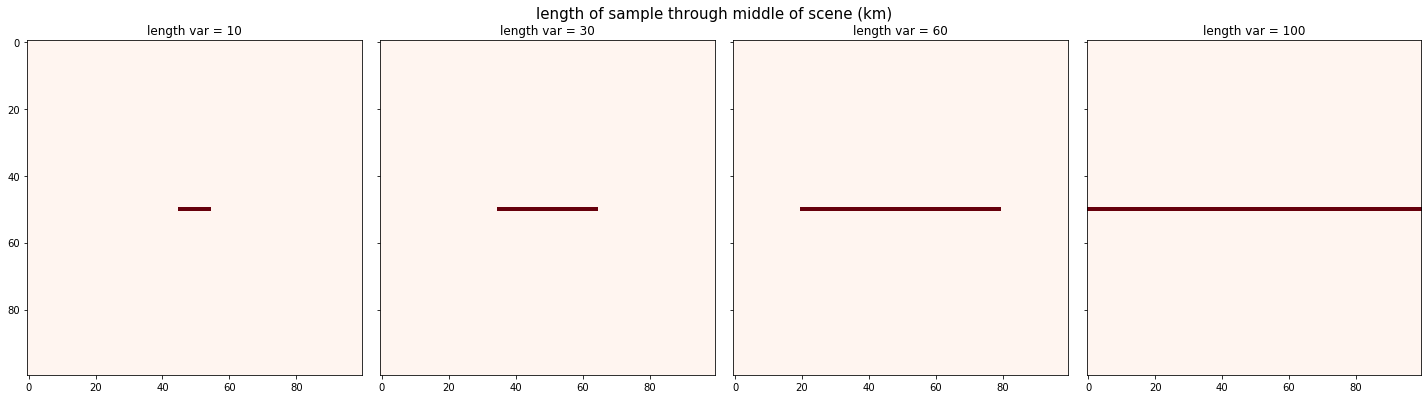

In [6]:
def sample_data_with_linelength(data_shape, linelength):
    """
    Given some data array, sample a line of pixels of length linelength through the middle of it
    
    Returns tuple of sample mean, standard deviation, and sample count
    """
    if linelength>data_shape[1]:
        raise IndexError('linelength is longer than the data it is meant to sample')
#     sample = data[data.shape[0]//2,(data.shape[1]//2-linelength//2):(data.shape[1]//2+ceil(linelength/2))]
    data_slice = (slice(data_shape[0]//2,data_shape[0]//2+1,None),slice((data_shape[1]//2-linelength//2),(data_shape[1]//2+ceil(linelength/2))))
#     data[slice(data_shape[0]//2,data.shape[0]//2+1,None),slice((data.shape[1]//2-linelength//2),(data.shape[1]//2+ceil(linelength/2)))]
#     return (np.nanmean(sample), np.nanstd(sample), np.sum(~np.isnan(sample)))
    return data_slice

linelengths = (10, 30, 60, 100)
linelength_name = 'length of sample through middle of scene (km)'

linear_sample = SampleStrategy(sample_data_with_linelength, linelengths, linelength_name)
linear_sample.visualize()

We can also define some alternative sampling strategies. Below are two: one is sampling random pixels as a fraction of the entire scene. This is not a realistic sampling strategy for aircraft, but may help tell us something about how the variable behaves. Below that we have a sampling strategy for multiple passes across the entire box, which is a valid sampling strategy

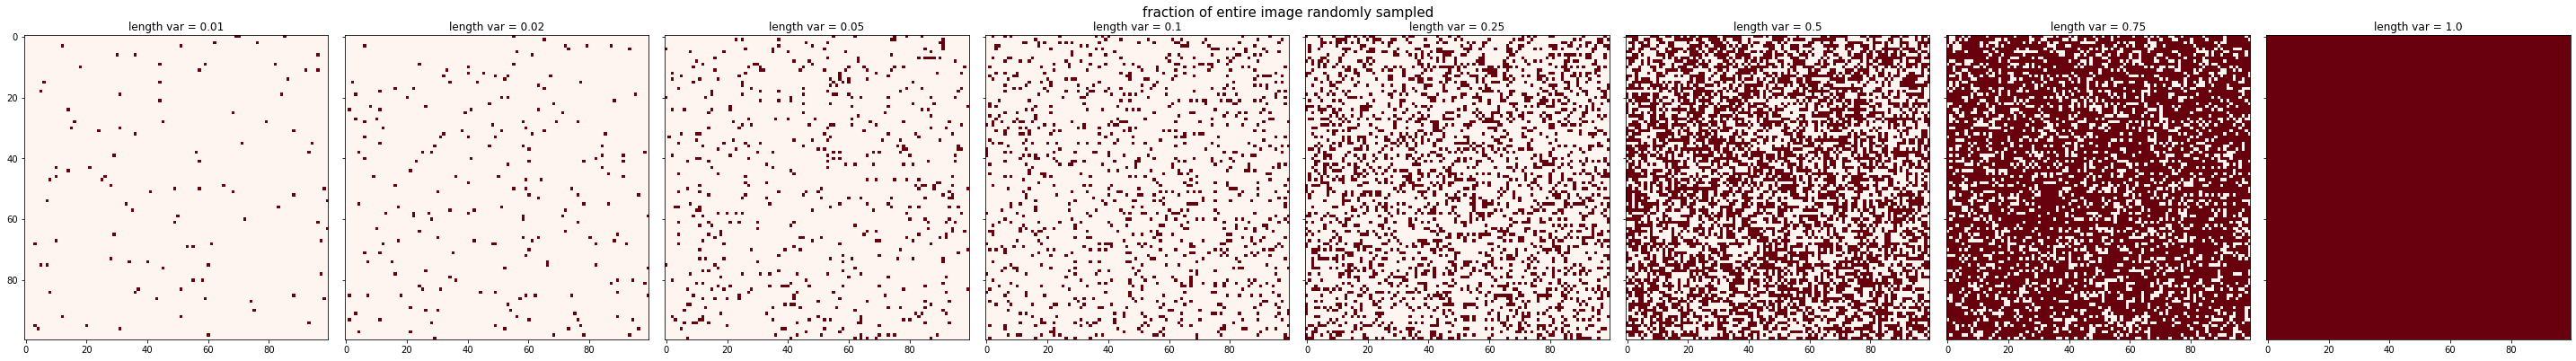

In [7]:
def sample_data_random_pixels(data_shape, fraction):
    """
    Given some data array, randomly sample some fraction of its pixels
    
    Returns tuple of sample mean, standard deviation, and sample count
    """
    data_size = np.prod(data_shape)
    num_samples = int(data_size*fraction)
    arr = np.array([0] * (data_size-num_samples) + [1] * num_samples)
    np.random.shuffle(arr)
#     print(arr.shape)
    sample = arr.reshape(data_shape)
    return(sample)
#     sample = np.random.choice(data.flatten(), size=int(np.prod(data.shape)*fraction), replace=False)
    
#     return (np.nanmean(sample), np.nanstd(sample), np.sum(~np.isnan(sample)))

fractions = np.array([1, 2, 5, 10, 25, 50, 75, 100])/100
fraction_name = "fraction of entire image randomly sampled"

random_sample = SampleStrategy(sample_data_random_pixels, fractions, fraction_name)
random_sample.visualize()

And lastly the sampling strategy to test below is flying in lines entirely across the 100x100 scene, varying the number of lines, with a fixed spacing between lines. 

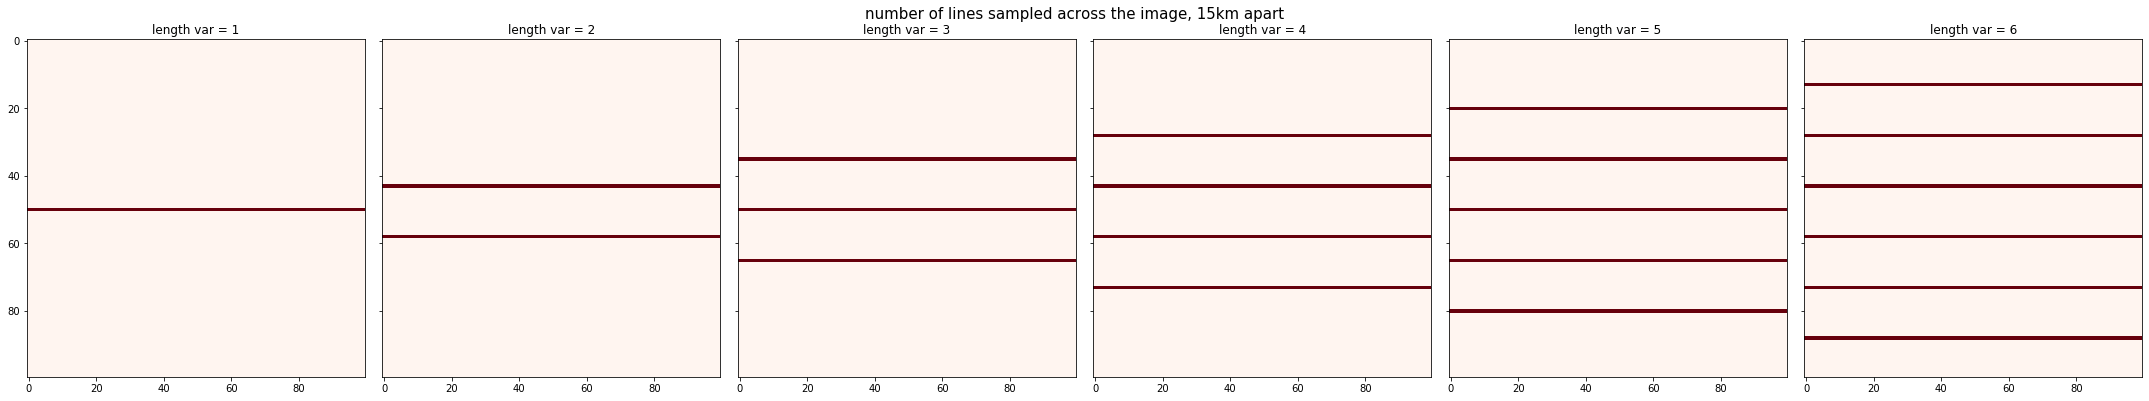

In [8]:
def sample_data_with_nlines(data_shape, nlines, linespacing=15):
    """
    Given some data array, sample with n lines across it, spaced out by linespacing, centered in the middle
    
    Returns tuple of sample mean, standard deviation, and sample count
    """
    if nlines*linespacing>data_shape[0]:
        raise IndexError('too many lines, too far apart') 
    low_idx = data_shape[0]//2 - linespacing*(nlines-1)//2
    high_idx = (data_shape[0]//2 + linespacing*(nlines-1)//2)+1 + linespacing%2
    
    data_slice = (slice(low_idx, high_idx, linespacing), slice(None, None, None))
    return data_slice

nlines = [1, 2, 3, 4, 5, 6]
nlines_name = "number of lines sampled across the image, 15km apart"
line_sample_15 = SampleStrategy(lambda x,y: sample_data_with_nlines(x, y, linespacing=15), nlines, nlines_name)
line_sample_15.visualize()

Next we need to create a function to take an entire MODIS granule, chop out a bunch of 1&deg;x1&deg; boxes, and for each box and each variable of interest, sample it at varying lengths. We can plug in different SampleStrategies here. 

Note that while it would generally be better practice to split such a large function up, here we intend to parallelize the processing over a list of granules, and so we want a function that does the whole job for a single granule. This can be optimized later. A better way would be to preprocess the MODIS data to extract out the 1x1 boxes and save that somewhere.

In [11]:
def sample_whole_granule(granule_name, sample_strategy):
    """Chop up a MODIS granule and sample variables of interest at multiple lengths.

    1) Open dataset, initialize counters/dicts for storing output data
    2) Looping over each candidate 1x1 box:
        a) filter out potentially bad granules
        b) for each variable to sample:
            i) for each candidate line length
                I) sample!
    
    """
    ds = xr.open_dataset(granule_name)
# #     linelengths = [10, 20, 40, 60, 80, 100]
# #     fractions = 
#     nlines = 
    
    length_5k = 20 #up the swath, on the 5 km grid
    width_5k = 20 #across the swath
    
    good, bad_solar, bad_sensor, land, ice = 0, 0, 0, 0, 0 # these are to keep track of why slices are rejected
    i_arr, j_arr = [], [] #to keep track of each i and j index
    cloud_top_heights = [] #
    #to keep track of means, etc...
    means_dict = {v: [] for v in col_names}
    stds_dict = {v: [] for v in col_names}
    nsamples_dict = {v: [] for v in col_names}
    
    
    for i_5k_start in ds['Cell_Along_Swath_5km:mod06'].values[10:-length_5k:length_5k]:
        for j_5k_start in ds['Cell_Across_Swath_5km:mod06'].values[10:-width_5k:width_5k]:
#             scene_has_all_missing_data_in_one_sample_flag = False
            i_5k_end = i_5k_start + length_5k
            j_5k_end = j_5k_start + width_5k
            i_1k_start, i_1k_end, j_1k_start, j_1k_end = i_5k_start*5, i_5k_end*5, j_5k_start*5, j_5k_end*5
           
                
            #filtering for high solar zenith, high sensor zenith, land, and ice...
            try:
                if ds.Solar_Zenith[i_5k_start, j_5k_start]>45 or ds.Solar_Zenith[i_5k_end, j_5k_end]>45:
                    bad_solar += 1
                    continue
            except IndexError as e:
                print(ds.Solar_Zenith.shape)
                raise e
            if ds.Sensor_Zenith[i_5k_start, j_5k_start]>45 or ds.Sensor_Zenith[i_5k_end, j_5k_end]>45:
                bad_sensor += 1
                continue
            cld_mask = ds.Cloud_Mask_5km.isel(
                {'Cell_Along_Swath_5km:mod06': slice(i_5k_start,i_5k_end+1), 'Cell_Across_Swath_5km:mod06': slice(j_5k_start,j_5k_end+1), 'Cloud_Mask_5km_Num_Bytes:mod06': 0}).values.astype(int)
            land_flag = np.max(cld_mask>>6&0b11)>0 #true if land is anywhere along line sample
            if land_flag:
                land += 1
                continue
            cld_phase_line = ds.Cloud_Phase_Infrared_1km.isel({'Cell_Along_Swath_1km:mod06': slice(i_1k_start,i_1k_end+1), 'Cell_Across_Swath_1km:mod06': slice(j_1k_start,j_1k_end+1)})
            ice_flag = np.mean([i in (0,1) for i in cld_phase_line.values.flatten()]) < 0.95 #true if more than 5% of pixels aren't either liquid or clear               
            if ice_flag:
                ice += 1
                continue
            else: 
                good += 1
            

            #now we can start adding some data. First, let's add a cloud fraction var
            ds['Cloud_Frac'] = ds['Cloud_Phase_Infrared_1km'].where(ds['Cloud_Phase_Infrared_1km']<2)
            i_arr.append(i_1k_start)
            j_arr.append(j_1k_start)
            
            
            for var in col_names:
                var_data = ds[var].isel({'Cell_Along_Swath_1km:mod06': slice(i_1k_start,i_1k_end+1),
                                     'Cell_Across_Swath_1km:mod06': slice(j_1k_start,j_1k_end+1)}).values
                #fill in partial cloud pixels
                if var+'_PCL' in ds.data_vars.keys():
                    data_PCL = ds[var+'_PCL'].isel({'Cell_Along_Swath_1km:mod06': slice(i_1k_start,i_1k_end+1),
                                                    'Cell_Across_Swath_1km:mod06': slice(j_1k_start,j_1k_end+1)}).values
                    var_data[np.isnan(var_data)] = data_PCL[np.isnan(var_data)]
                
                #empty lists for storing stats for this variable
                var_means, var_stds, var_nsamples = [], [], []
                var_means_r, var_stds_r, var_nsamples_r = [], [], []
                
                if var == 'cloud_top_height_1km':
                    cloud_top_heights.append(np.nanmean(var_data))
                    cloud_top_heights.append(np.nanmean(var_data)) #note: appending twice because we do 2 samples per scene
            
    

                #now sampling over lengths
                for length in sample_strategy.length_var:
            
                    (mean, std_dev, nsamples) = sample_strategy.sample(var_data, length)
                    var_means.append(mean)
                    var_stds.append(std_dev)
                    var_nsamples.append(nsamples)
                    
                    (mean, std_dev, nsamples) = sample_strategy.sample(var_data.T, length)

                    var_means_r.append(mean)
                    var_stds_r.append(std_dev)
                    var_nsamples_r.append(nsamples)
                
                means_dict[var].append(np.array(var_means))
                stds_dict[var].append(np.array(var_stds))
                nsamples_dict[var].append(np.array(var_nsamples))

                means_dict[var].append(np.array(var_means_r))
                stds_dict[var].append(np.array(var_stds_r))
                nsamples_dict[var].append(np.array(var_nsamples_r))
              
            
    for d in [means_dict, stds_dict, nsamples_dict]:
        for i,(k,v) in enumerate(d.items()):
            if len(v) == 0:
                d[k] = np.array([np.nan]*len(sample_strategy.length_var))
                cloud_top_heights = [np.nan]
            else:
                d[k] = np.vstack(v)
                
#     print(len(cloud_top_heights))
#     print(len(means_dict['cloud_top_height_1km']))
            
    return_dict = {'i_arr': i_arr,
                       'j_arr': j_arr,
                       'cloud_top_heights': np.array(cloud_top_heights),
#                        'sample_strategy': sample_strategy,
                       'gran_name': granule_name,
                       'means_dict': means_dict,
                       'stds_dict': stds_dict,
                       'nsamples_dict': nsamples_dict,
                       'counts': (good, bad_solar, bad_sensor, land, ice),
                      }
    return(return_dict)

In [56]:
#using the multiprocessing library to parallelize over different modis files
#NOTE ON PARALLEL EXECUTION:
#This is done here because it's being done in a notebook.
#for a larger experiment it should be done in a separate script on the cluster
def worker(modis_file):
    print(f'working on {os.path.basename(modis_file)}')
    sample_strategy = line_sample_15
    samples = sample_whole_granule(modis_file, sample_strategy)
    return samples

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='Mean of empty slice')
        warnings.filterwarnings(action='ignore', message='Degrees of freedom <= 0')
        pool = mp.Pool(processes = 7)
        all_results = pool.map(worker, random.sample(all_modis_files, 60))

working on MYD06_L2.A2015230.0050.061.2018052031357.hdf
working on MYD06_L2.A2015204.0200.061.2018051120848.hdf
working on MYD06_L2.A2015187.0435.061.2018051035844.hdf
working on MYD06_L2.A2015185.2240.061.2018051005618.hdf
working on MYD06_L2.A2015182.0435.061.2018050235142.hdf
working on MYD06_L2.A2015223.2050.061.2018052075603.hdf
working on MYD06_L2.A2015235.1445.061.2018052071544.hdf
working on MYD06_L2.A2015216.1550.061.2018052050512.hdf
working on MYD06_L2.A2015236.0700.061.2018052073427.hdf
working on MYD06_L2.A2015215.0155.061.2018052040720.hdf
working on MYD06_L2.A2015239.0050.061.2018052162533.hdf
working on MYD06_L2.A2015241.0405.061.2018052172008.hdf
working on MYD06_L2.A2015231.1800.061.2018052022509.hdf
working on MYD06_L2.A2015192.1250.061.2018051094922.hdf
working on MYD06_L2.A2015219.1130.061.2018052041705.hdf
working on MYD06_L2.A2015234.0025.061.2018052062319.hdf
working on MYD06_L2.A2015227.1155.061.2018052054904.hdf
working on MYD06_L2.A2015228.0245.061.2018052060

Let's save that for future use...

In [57]:
with open('/home/disk/p/jkcm/Scribbles/sample_length_vs_cloudvar_linesample15_size60.pickle', 'wb') as f:
    pickle.dump(all_results, f)

#can load later with the following line:
# all_results = pickle.load

In [58]:
sample_strategy = line_sample_15

We just need to unpack the result from our parallelized execution: all_results is a list of results, one for each granule. for each result, we have a dict of inf

In [85]:
good_counts = np.sum([i['counts'][0] for i in all_results])
bad_solar = np.sum([i['counts'][1] for i in all_results])
bad_sensor = np.sum([i['counts'][2] for i in all_results])
land = np.sum([i['counts'][3] for i in all_results])
ice = np.sum([i['counts'][4] for i in all_results])
print(f'good: {good_counts}, bad solar: {bad_solar}, bad sensor: {bad_sensor}, land: {land}, ice: {ice}')
total = good_counts+bad_solar+bad_sensor+land+ice
all_means = {}
all_stds = {}
all_nsamples = {}
all_sems = {}
all_mdc = {}
length_var = sample_strategy.length_var
length_var_name = sample_strategy.length_var_name
for var in col_names:
    factor = 100 if var=='Cloud_Frac' else 1
    all_means[var] = np.vstack([i['means_dict'][var] for i in all_results])*factor
    all_stds[var] = np.vstack([i['stds_dict'][var] for i in all_results])*factor
    all_nsamples[var] = np.vstack([i['nsamples_dict'][var] for i in all_results])
    
    mdc_factor = 1.96*np.sqrt(2)
    sem = all_stds[var]/np.sqrt(all_nsamples[var])
    all_sems[var] = sem
    all_mdc[var]  = sem*mdc_factor
    
all_cths = np.hstack([i['cloud_top_heights'] for i in all_results])
print(total, len(all_means['Cloud_Frac']))
diff_from_final_means = {k: np.abs(v - v[:,-1][:,None]) for k,v in all_means.items()}


good: 1653, bad solar: 6399, bad sensor: 1759, land: 2652, ice: 1217
13680 3337


In [83]:
heights = [(0,1000), (1000,2000), (2000,3000), (0, 3000)]
cols = ['C0', 'C1', 'C2', 'k']

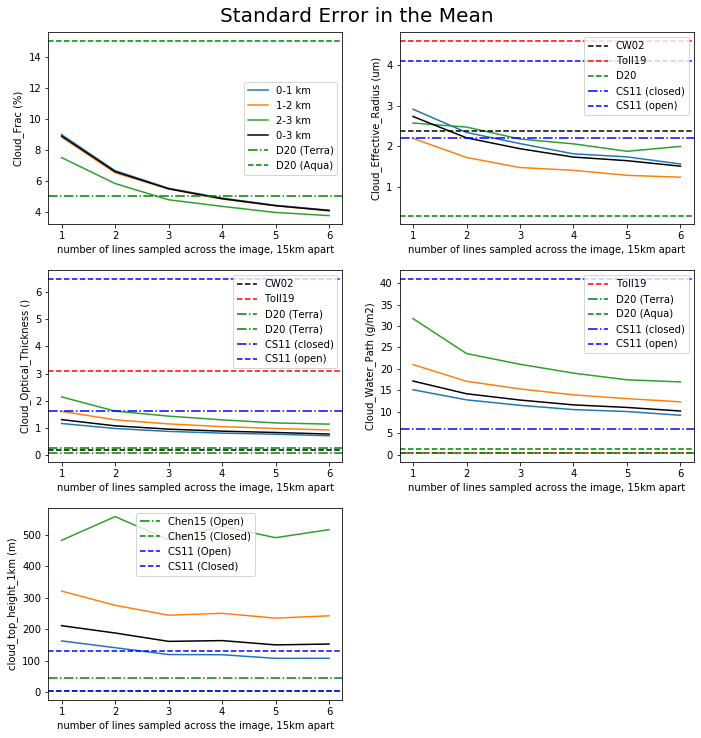

In [84]:
fig, axg = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axl = axg.flatten()
stat_to_plot, stat_name = all_sems, 'Standard Error in the Mean'
for i, (ax, name, units) in enumerate(zip(axl[:-1], col_names, col_units)):
    for j, (lower, upper) in enumerate(heights):
        good_idx = list(np.logical_and(all_cths>lower, all_cths<upper))
        label = f'{lower//1000}-{upper//1000} km'
        if not i==0:
            label=None
        var = stat_to_plot[name][good_idx]
        ax.plot(length_var, np.nanmean(var, axis=0), label=label, c=cols[j])
        ax.set_ylabel(f'{name} ({units})')
        ax.set_xlabel(length_var_name)
#         if i==0:
#             ax.legend()
    
#CF lit values
axl[0].axhline(5, label='D20 (Terra)', ls='-.', c='g')
axl[0].axhline(15, label='D20 (Aqua)', ls='--', c='g')

axl[0].legend()
    
#CER lit values
axl[1].axhline(2.37, label='CW02', ls='--', c='k')
axl[1].axhline(4.6, label='Toll19', ls='--', c='r')
axl[1].axhline(0.28, label='D20', ls='--', c='g')
axl[1].axhline(2.2, label='CS11 (closed)', ls='-.', c='b')
axl[1].axhline(4.1, label='CS11 (open)', ls='--', c='b')
axl[1].legend()

#COT lit values
axl[2].axhline(0.18, label='CW02', ls='--', c='k')
axl[2].axhline(3.1, label='Toll19', ls='--', c='r')
axl[2].axhline(0.24, label='D20 (Terra)', ls='-.', c='g')
axl[2].axhline(0.05, label='D20 (Terra)', ls='-.', c='g')
axl[2].axhline(1.6, label='CS11 (closed)', ls='-.', c='b')
axl[2].axhline(6.5, label='CS11 (open)', ls='--', c='b')
axl[2].legend()

#LWP lit values
axl[3].axhline(0.3, label='Toll19', ls='--', c='r')
axl[3].axhline(0.49, label='D20 (Terra)', ls='-.', c='g') #Terra
axl[3].axhline(1.32, label='D20 (Aqua)', ls='--', c='g') #Aqua
axl[3].axhline(6, label='CS11 (closed)', ls='-.', c='b')
axl[3].axhline(41, label='CS11 (open)', ls='--', c='b')
axl[3].legend()

#CTH lit values
axl[4].axhline(46, label='Chen15 (Open)', ls='-.', c='g')
axl[4].axhline(4, label='Chen15 (Closed)', ls='--', c='g')
axl[4].axhline(131, label='CS11 (Open)', ls='--', c='b')
axl[4].axhline(5, label='CS11 (Closed)', ls='--', c='b')
axl[4].legend()


plt.suptitle(stat_name, y=1.02, fontsize=20)
plt.tight_layout()
axl[-1].axis('off')
fig.show()

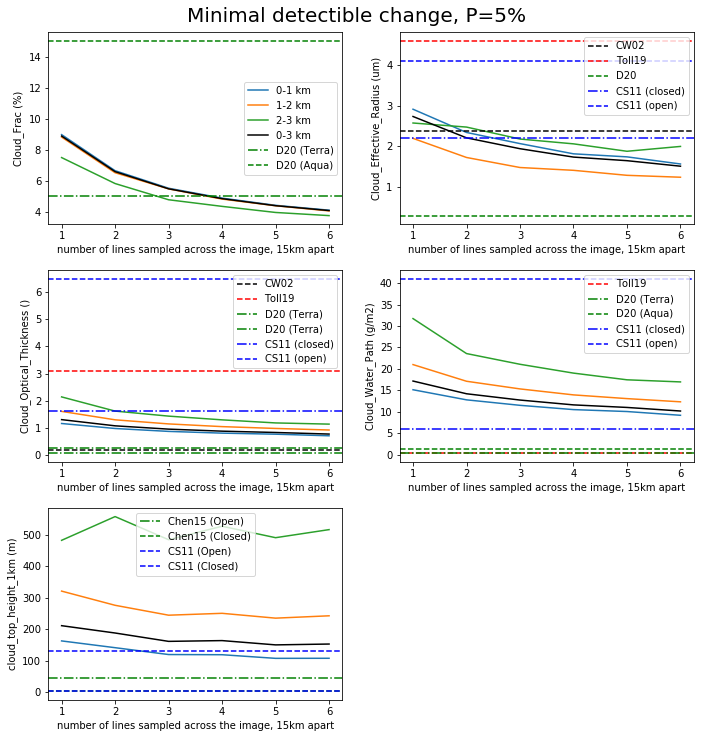

In [87]:
fig, axg = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axl = axg.flatten()
stat_to_plot, stat_name = all_mdc, 'Minimal detectible change, P=5%'
for i, (ax, name, units) in enumerate(zip(axl[:-1], col_names, col_units)):
    for j, (lower, upper) in enumerate(heights):
        good_idx = list(np.logical_and(all_cths>lower, all_cths<upper))
        label = f'{lower//1000}-{upper//1000} km'
        if not i==0:
            label=None
        var = stat_to_plot[name][good_idx]
        ax.plot(length_var, np.nanmean(var, axis=0), label=label, c=cols[j])
        ax.set_ylabel(f'{name} ({units})')
        ax.set_xlabel(length_var_name)
#         if i==0:
#             ax.legend()
    
#CF lit values
axl[0].axhline(5, label='D20 (Terra)', ls='-.', c='g')
axl[0].axhline(15, label='D20 (Aqua)', ls='--', c='g')

axl[0].legend()
    
#CER lit values
axl[1].axhline(2.37, label='CW02', ls='--', c='k')
axl[1].axhline(4.6, label='Toll19', ls='--', c='r')
axl[1].axhline(0.28, label='D20', ls='--', c='g')
axl[1].axhline(2.2, label='CS11 (closed)', ls='-.', c='b')
axl[1].axhline(4.1, label='CS11 (open)', ls='--', c='b')
axl[1].legend()

#COT lit values
axl[2].axhline(0.18, label='CW02', ls='--', c='k')
axl[2].axhline(3.1, label='Toll19', ls='--', c='r')
axl[2].axhline(0.24, label='D20 (Terra)', ls='-.', c='g')
axl[2].axhline(0.05, label='D20 (Terra)', ls='-.', c='g')
axl[2].axhline(1.6, label='CS11 (closed)', ls='-.', c='b')
axl[2].axhline(6.5, label='CS11 (open)', ls='--', c='b')
axl[2].legend()

#LWP lit values
axl[3].axhline(0.3, label='Toll19', ls='--', c='r')
axl[3].axhline(0.49, label='D20 (Terra)', ls='-.', c='g') #Terra
axl[3].axhline(1.32, label='D20 (Aqua)', ls='--', c='g') #Aqua
axl[3].axhline(6, label='CS11 (closed)', ls='-.', c='b')
axl[3].axhline(41, label='CS11 (open)', ls='--', c='b')
axl[3].legend()

#CTH lit values
axl[4].axhline(46, label='Chen15 (Open)', ls='-.', c='g')
axl[4].axhline(4, label='Chen15 (Closed)', ls='--', c='g')
axl[4].axhline(131, label='CS11 (Open)', ls='--', c='b')
axl[4].axhline(5, label='CS11 (Closed)', ls='--', c='b')
axl[4].legend()


plt.suptitle(stat_name, y=1.02, fontsize=20)
plt.tight_layout()
axl[-1].axis('off')
fig.show()

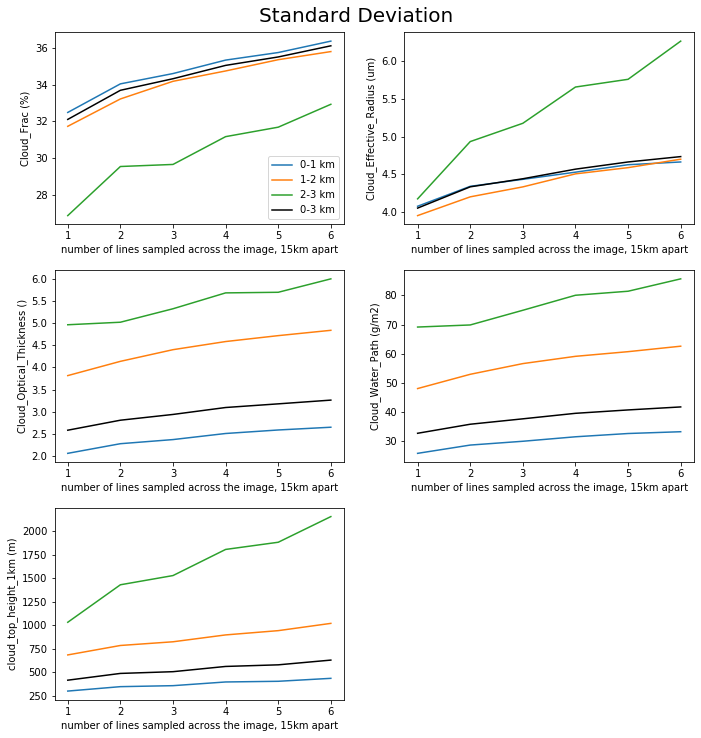

In [78]:
fig, axg = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axl = axg.flatten()
stat_to_plot, stat_name = all_stds, 'Standard Deviation'
for i, (ax, name, units) in enumerate(zip(axl[:-1], col_names, col_units)):
    for j, (lower, upper) in enumerate(heights):
        good_idx = list(np.logical_and(all_cths>lower, all_cths<upper))
        label = f'{lower//1000}-{upper//1000} km'
        var = stat_to_plot[name][good_idx]
        ax.plot(length_var, np.nanmean(var, axis=0), label=label, c=cols[j])
        ax.set_ylabel(f'{name} ({units})')
        ax.set_xlabel(length_var_name)
        if i==0:
            ax.legend()
    
    
plt.suptitle(stat_name, y=1.02, fontsize=20)
plt.tight_layout()
axl[-1].axis('off')
fig.show()

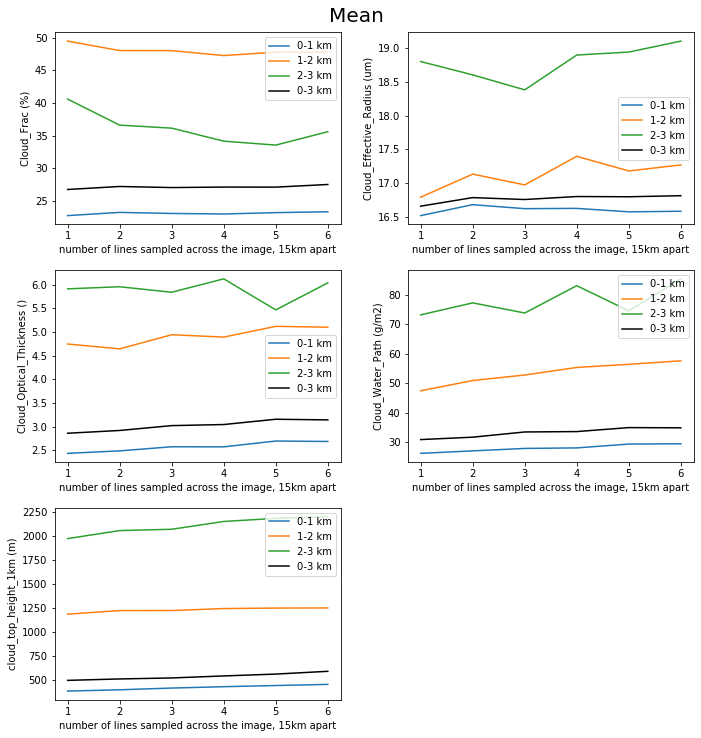

In [79]:
fig, axg = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
axl = axg.flatten()
stat_to_plot, stat_name = all_means, 'Mean'
for i, (ax, name, units) in enumerate(zip(axl[:-1], col_names, col_units)):
    for j, (lower, upper) in enumerate(heights):
        good_idx = list(np.logical_and(all_cths>lower, all_cths<upper))
        label = f'{lower//1000}-{upper//1000} km'
        var = stat_to_plot[name][good_idx]
        ax.plot(length_var, np.nanmedian(var, axis=0), label=label, c=cols[j])
        ax.set_ylabel(f'{name} ({units})')
        ax.set_xlabel(length_var_name)
#         if i==0:
        ax.legend()
    
    
plt.suptitle(stat_name, y=1.02, fontsize=20)
plt.tight_layout()
axl[-1].axis('off')
fig.show()

In [ ]:
#vary starting i
#try throwing out all scenes where ANY sample has a NAN
#also look at frac of nan scenes as function of sample size
#look at L3 joint product statistics discussion - Pincus Oreopoulos
#do fat sample fat sample
#do short striped lines (10km instead of 100km)